In [1]:
import torch

import sys
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def dist_metric(x,y):
    return(torch.norm(x-y).item())

def calculate_action(dist_list,k):
    action = torch.tensor([0.0,0.0,0.0])
    top_k_weights = torch.zeros((k,))
    for i in range(k):
        top_k_weights[i] = dist_list[i][0]

    top_k_weights = softmax(-1*top_k_weights)
    for i in range(k):
        action = torch.add(top_k_weights[i]*dist_list[i][1], action)

    return(action)

def extract_image(full_path):
    parts = full_path.split('/')
    return '/'.join(parts[-2:])

In [3]:
params = {}
params['root_dir'] = '/home/arvind/CMU/MAIL/VINN/VINN-Main/VINN-Sculpt/VINN-ACT/'  #'/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/' # This was changed
params['img_size'] = 2048
params['layer'] = ''
params['model'] = 'PointBERT'
params['representation_model_path'] = 'chkpts/BYOL_PC_100_X_batch_60.pt' # This was changed
params['eval'] = 0
params['representation'] = 0
params['dataset'] = 'X_Datasets'
params['architecture'] = ''
params['t'] = 0
 

sys.path.append(params['root_dir'] + 'representation_models')
sys.path.append(params['root_dir'] + 'dataloaders')
print
from run_model import Encoder
from XDataset_PC import XDataset_PC

encoder = Encoder(params)
params['folder'] =  '/home/arvind/CMU/MAIL/VINN/VINN-Main/VINN-Sculpt/VINN-ACT/representation_data/X_all/train_all' # '/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_data/X_all/train_all'
train_dataset = XDataset_PC(params, encoder)
params['folder'] =  '/home/arvind/CMU/MAIL/VINN/VINN-Main/VINN-Sculpt/VINN-ACT/representation_data/X_all/val_all'# '/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_data/X_all/val_all_trial'
val_dataset = XDataset_PC(params, encoder)



 config:  {'NAME': 'PointTransformer', 'trans_dim': 384, 'depth': 12, 'drop_path_rate': 0.1, 'cls_dim': 40, 'num_heads': 6, 'group_size': 32, 'num_group': 64, 'encoder_dims': 256}


2024-02-25 13:59:15,776 - Transformer - INFO - missing_keys
2024-02-25 13:59:15,776 - Transformer - INFO - Some model parameters or buffers are not found in the checkpoint:
  cls_head_finetune.0.{weight, bias}
  cls_head_finetune.3.{weight, bias}
2024-02-25 13:59:15,777 - Transformer - INFO - unexpected_keys
2024-02-25 13:59:15,777 - Transformer - INFO - The checkpoint state_dict contains keys that are not used by the model:
  mask_token
  lm_head.{weight, bias}
2024-02-25 13:59:15,777 - Transformer - INFO - [Transformer] Successful Loading the ckpt from pointBERT/point-BERT-weights/Point-BERT.pth
100%|██████████| 12/12 [00:00<00:00, 16.51it/s]


In [4]:
mseLoss = torch.nn.MSELoss()
ceLoss = torch.nn.CrossEntropyLoss()

softmax = torch.nn.Softmax(dim=0)
print(len(val_dataset))

80


In [5]:
def calculate_nearest_neighbors(query_set, dataset, k):
    loss = [0 for i in range(k)]
    selected_paths = []
    for query_index in tqdm(range(len(query_set))):
        dist_list = []
        query_embedding, query_translation, query_rotation, query_gripper, query_path = query_set[query_index]

        for dataset_index in range(len(dataset)):

            dataset_embedding, dataset_translation, dataset_rotation, dataset_gripper, dataset_path = dataset[dataset_index]
            distance = dist_metric(query_embedding, dataset_embedding)
            dist_list.append((distance, dataset_translation, dataset_path))

        dist_list = sorted(dist_list, key = lambda tup: tup[0])
        
        for i in range(k):
            pred_action = calculate_action(dist_list, i+1)
            loss[i] += mseLoss(pred_action,query_translation).item()
            if i == 10:
                selected_paths.append((extract_image(query_path), [extract_image(dist_list[j][2]) for j in range(i+1)]))

        

    return(loss, selected_paths)

In [6]:
val_loss, paths = calculate_nearest_neighbors(val_dataset, train_dataset, 50)

100%|██████████| 80/80 [00:01<00:00, 47.37it/s]


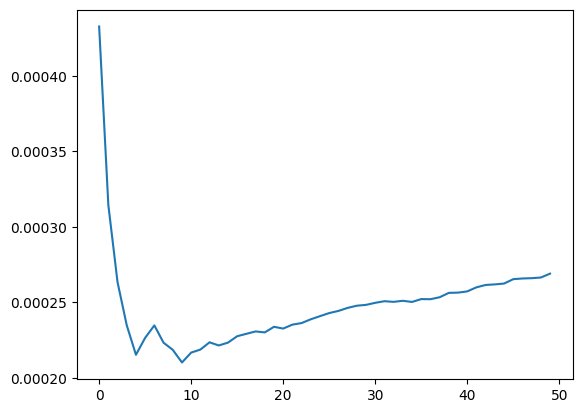

In [7]:
val_loss_scaled = [i / len(val_dataset) for i in val_loss]
x_axis = [i for i in range(len(val_loss))]
plt.plot(x_axis, val_loss_scaled)

In [9]:
print(paths[3])

('run_pc_18/0003.npy', ['run_pc_12/0003.npy', 'run_pc_16/0003.npy', 'run_pc_15/0007.npy', 'run_pc_15/0000.npy', 'run_pc_13/0006.npy', 'run_pc_17/0002.npy', 'run_pc_17/0000.npy', 'run_pc_19/0003.npy', 'run_pc_10/0003.npy', 'run_pc_17/0005.npy', 'run_pc_5/0001.npy'])


In [12]:
import numpy as np
np.argmin(np.array(val_loss_scaled))

35

In [9]:
# test_loss = calculate_nearest_neighbors(test_dataset, train_dataset, 50)

NameError: name 'test_dataset' is not defined

In [ ]:
test_loss_scaled = [i / len(test_dataset) for i in test_loss]
x_axis = [i for i in range(len(test_loss))]
plt.plot(x_axis, test_loss_scaled)

In [ ]:
min(test_loss_scaled)

0.19428218364976935